# B21 Validation

In [25]:
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from Utils import read_pickle, read_json

# Load Data & Model

In [2]:
process = "b21"

# optimization datasets
opt_01_df = pd.read_csv(f'../outputs/{process}_opt_results_01.csv').set_index('Date')
opt_1_df = pd.read_csv(f'../outputs/{process}_opt_results_1.csv').set_index('Date')
opt_10_df = pd.read_csv(f'../outputs/{process}_opt_results_10.csv').set_index('Date')

opt_01_df = opt_01_df.drop(['Success'], axis = 1)
opt_1_df = opt_1_df.drop(['Success'], axis = 1)
opt_10_df = opt_10_df.drop(['Success'], axis = 1)

opt_01_df.index = pd.to_datetime(opt_01_df.index)
opt_1_df.index = pd.to_datetime(opt_1_df.index)
opt_10_df.index = pd.to_datetime(opt_10_df.index)

# model
mod = read_pickle(f'../models/{process}_optimization_model.pkl')

# testing datasets
test_df = pd.read_csv(f'../outputs/{process}_test_df.csv').set_index('Date')
test_df.index = pd.to_datetime(test_df.index)

# tags dict
tags_dict = read_json(f"../outputs/{process}_tags_dict.json")

# Format Data

In [3]:
ctrl_tags = tags_dict['controllable']
indct_tags = tags_dict['noncontrollable']

mod_ctrl_tags = [tag for tag in ctrl_tags if tag in test_df.columns]
mod_indct_tags = [tag for tag in indct_tags if tag in test_df.columns]

# response tag after EDA
response = 'RESPONSE'

indct_df = test_df.loc[:, mod_indct_tags]
resp_df = test_df.loc[:, response]

In [4]:
def combine_opt_original(optimal_df):
    optimized_df = pd.concat([optimal_df, indct_df, resp_df], axis = 1)
    optimized_df.columns = [tag.replace('_Optimized', '') for tag in optimized_df.columns]
    return optimized_df

comb_opt_01_df = combine_opt_original(opt_01_df)
comb_opt_1_df = combine_opt_original(opt_1_df)
comb_opt_10_df = combine_opt_original(opt_10_df)

# Make Predictions

In [18]:
def predict_opt(optimal_df):
    mod_preds = pd.DataFrame({'preds': mod.predict(optimal_df.loc[:, [*mod_ctrl_tags, *mod_indct_tags]])})
    mod_preds.index = optimal_df.index
    
    return mod_preds

preds_01 = predict_opt(comb_opt_01_df)
preds_1 = predict_opt(comb_opt_1_df)
preds_10 = predict_opt(comb_opt_10_df)
preds = predict_opt(test_df)

# Control Check

In [17]:
def check_ctrls(opt_df, df_string):
    print(df_string)
    for tag in mod_ctrl_tags:
        tag = tag + "_Optimized"
        below_zero = (opt_df[tag] < 0).sum()
        print(f'{tag} below 0: {below_zero}')
        
    print("")
    return

check_ctrls(opt_01_df, "opt_01")
check_ctrls(opt_1_df, "opt_1")
check_ctrls(opt_10_df, "opt_10")

opt_01
HPBH:221F003_Optimized below 0: 0
HPBH:221F011_Optimized below 0: 0
HPBH:221U829_Optimized below 0: 0

opt_1
HPBH:221F003_Optimized below 0: 0
HPBH:221F011_Optimized below 0: 0
HPBH:221U829_Optimized below 0: 0

opt_10
HPBH:221F003_Optimized below 0: 0
HPBH:221F011_Optimized below 0: 0
HPBH:221U829_Optimized below 0: 0



# Output Values

In [27]:
def plot_output(opt_preds_df, opt_string):
    print(opt_string)
    plt.plot(test_df['RESPONSE'], label = 'Actual');
    plt.plot(opt_preds_df, label = 'Optimized');
    plt.plot(preds, label = 'Predicted');
    plt.legend();
    plt.title('Response');
    plt.show();

    opt_mape = round(mean_absolute_percentage_error(test_df['RESPONSE'], opt_preds_df) * 100, 2)
    org_mape = round(mean_absolute_percentage_error(test_df['RESPONSE'], preds) * 100, 2)

    print("")
    print(f'MAPE before optimization: {org_mape}%')
    print(f'MAPE after optimization: {opt_mape}%')

    return

C = 0.01


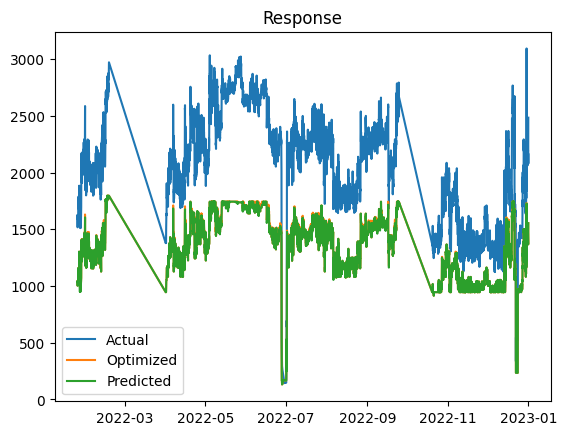


MAPE before optimization: 33.72%
C = 0.01 MAPE after optimization: 33.55%


In [28]:
plot_output(preds_01, "C = 0.01")

C = 1


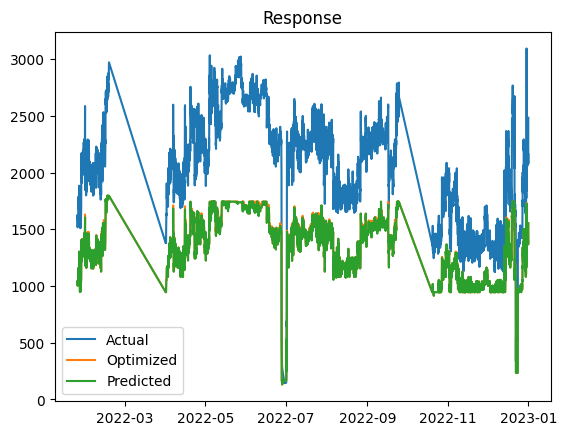


MAPE before optimization: 33.72%
C = 0.01 MAPE after optimization: 33.55%


In [29]:
plot_output(preds_1, "C = 1")

C = 1


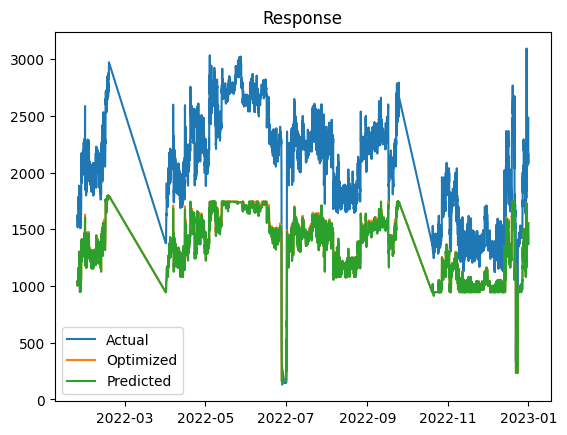


MAPE before optimization: 33.72%
C = 0.01 MAPE after optimization: 33.55%


In [30]:
plot_output(preds_10, "C = 1")

# Gas

In [53]:
def plot_controllable(comb_opt_df, opt_string, tag):
    print(opt_string)
    plt.plot(comb_opt_df[tag], label = f'Optimized {tag}');
    plt.plot(test_df[tag], label = f'Actual {tag}');
    plt.legend();
    plt.title(f'{tag}');
    plt.show();
    
    cont_diff = (test_df[tag] - comb_opt_df[tag]).sum()
    
    print(f'Reduction in {tag}: {cont_diff}')
    
    return

C = 0.01


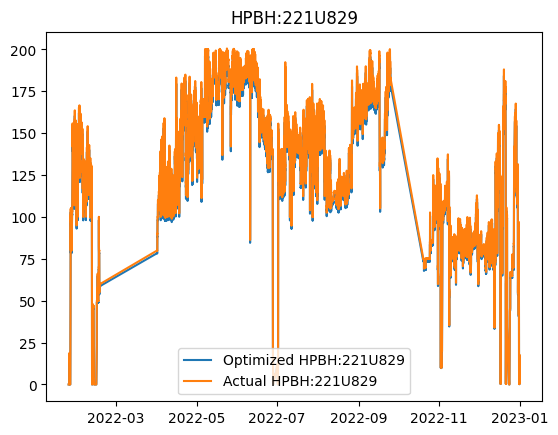

Reduction in HPBH:221U829: 29658.58188075271


In [56]:
plot_controllable(comb_opt_01_df, "C = 0.01", mod_ctrl_tags[2])

In [57]:
test_df.shape

(11216, 9)